# AI-Dermotologist

This is a mini project that aims to build a AI classifier for deadly **skin cancer diagnose**. <br>
The ultimate goal is distinguish **maglignant** [Melanoma](https://www.skincancer.org/skin-cancer-information/melanoma) (a.k.a black cancer, which is one of the most deadly cancer with only 15%-20% of survival rate) from **benign lesions** such as [nevus](http://missinglink.ucsf.edu/lm/dermatologyglossary/nevus.html) and [seborrheic keratoses](https://www.aad.org/public/diseases/bumps-and-growths/seborrheic-keratoses). <br>
The big motivation behind this project is that if Melanoma could be detected in its *early stage*, chances of cure will be much more optimistic. However, human dermotologists are not super accurate with this diagnose and there is a shortage per capita of them. <br>
The training, validation and test data of this project are pulled from the [ICIC 2017: Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a) challenge. In addition, this [paper](https://arxiv.org/pdf/1710.05006.pdf) provides a very comprehensive review of the state of the art approaches. <br>
Many of the techniques implemented in this notebook are inspired by the **[RECOD Titans at ISIC Chanlenge paper](https://arxiv.org/pdf/1710.05006.pdf)**(by Menegola A, Tavares J, Fornaciali M, Li LT, Avila S, Valle E. ) including *model selections, data augmentations, evaluation and SVM meta-learner.*

## Fastai
We are going to use **Fastai** libary in this notebook for prototyping. <br>
**Fastai** also provide excellent tools for hyper-parameter tuning, data cleaning, and other useful functions to make our iterative modelling provess easier

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import EarlyStoppingCallback

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
# import cv2
import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data
from torch import optim

from torchvision import datasets, transforms, models
from collections import OrderedDict


## Here we create our dataset from downloaded images in the 'data' folder

In [3]:
# We set max_warp to 0.0 since we don't have warping in this case

tfms = get_transforms(flip_vert=True, max_rotate=180.0,max_lighting=0.2, max_zoom=1.2, max_warp=0.0)

In [4]:
path = 'data'
bs = 64
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=114, bs=bs
                            ).normalize(imagenet_stats)

#### DataBunch is a fastai object that come with very handy properties that we can make use of
It's a good idea to run a sanity check on created dataset before going to actual prototyping

In [5]:
data.classes

['melanoma', 'nevus', 'seborrheic_keratosis']

In [6]:
data.c

3

In [7]:
data.train_ds

LabelList (2000 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data

In [8]:
data.valid_ds

LabelList (150 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data

In [9]:
data.device

device(type='cuda')

In [10]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Test: None>

### Let's do a visualization of our create dataset together with their labels

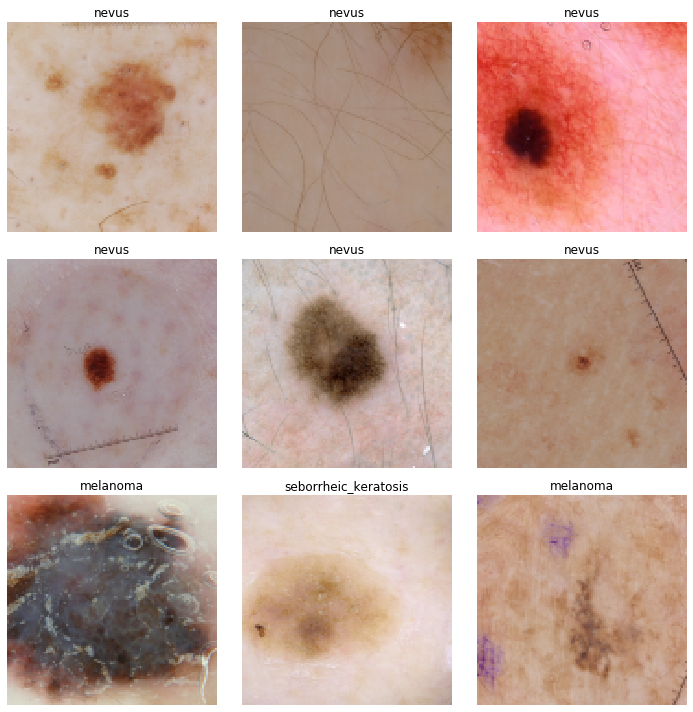

In [11]:
# we should see that the magnignant skin cancers are 
# actually pretty hard to distinguish
data.show_batch(rows=3, figsize = (10,10))

## Check the status of our GPU

In [12]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Total memory: 11719409664
Free memory: 10598481920
Used memory: 1120927744
Device 0 : b'GeForce GTX 1080 Ti'


In [13]:
bs = 64
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=114, bs=bs
                            ).normalize(imagenet_stats)
bs = 32
data2 = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=bs
                            ).normalize(imagenet_stats)

# Transfer learning
We create our model by downloading a pretrained ImageNet and modify its top layer according to the configuration of our dataset

## Model choice
There are going to be multiple models create in this notebook for ensemble learning.
We are going to start with a `ResNet34` and move to stronger learners.

## Metrics choice
We have chose accuracy and auc_roc_score to monitor how is our model doing during the training.
Note that: this is different from Scikit-learn in that the metrics we specified here has **no** impact on the training process. <br>
However, it's important to monitor the *metrics* that we are interested in in order to decide how will we further train our model.

In [16]:
top_3_accuracy = partial(top_k_accuracy, k=3)
learn = cnn_learner(data, models.resnet34, metrics = [accuracy, top_3_accuracy])

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

We can see that FastAI has already modified the last few layers for us, so that it has a multiclass classification setup for 3 outputs. <br>
Very efficient prototyping.

#### Use LR Finder to pick a good learning rate

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


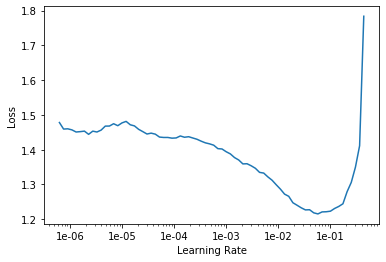

In [15]:
learn.recorder.plot()

#### Start training
The `fit_one_cycle()` methed are prooved to produce more consistent result
As for the `learning rate`, we pick the steepest slope. Make sure it's not too small here in the first training.

In [24]:
lr = 1e-3

In [31]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.381417,0.948798,0.586667,1.000000,02:41
1,1.135682,0.850029,0.620000,1.000000,02:34
2,0.967131,0.837853,0.626667,1.000000,02:38
3,0.862727,0.832540,0.633333,1.000000,02:32
4,0.810207,0.831597,0.620000,1.000000,02:39


In [32]:
learn.save('stage-1')

## Stage-2
Unfreeze the whole network and get ready to train all of it

In [33]:
learn.unfreeze()

### Finding the good learning rate for different layers

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


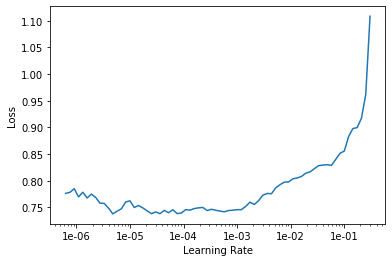

In [35]:
learn.recorder.plot()

#### Use `Slice()` to specify the lr_top and lr_bottom and everything in between

In [36]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.759247,0.798755,0.660000,1.000000,02:44
1,0.728295,0.770364,0.693333,1.000000,02:32
2,0.699246,0.732151,0.713333,1.000000,02:33
3,0.674623,0.731822,0.700000,1.000000,02:38
4,0.648426,0.728514,0.706667,1.000000,02:35


In [37]:
learn.save('stage-2')

In [17]:
bs = 32
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=bs
                            ).normalize(imagenet_stats)
learn.data = data

In [18]:
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [40]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


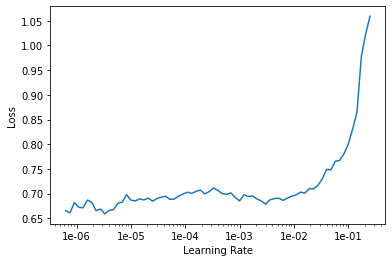

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr = 1e-3

In [43]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.676855,0.710088,0.700000,1.000000,02:34
1,0.677053,0.646811,0.720000,1.000000,02:38
2,0.637435,0.658036,0.753333,1.000000,02:36
3,0.610883,0.647105,0.753333,1.000000,02:39
4,0.592475,0.668332,0.720000,1.000000,02:35


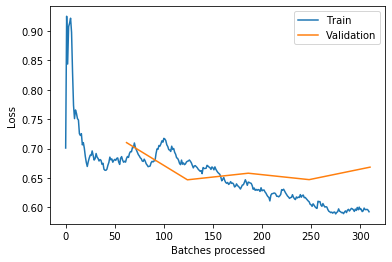

In [44]:
# comment: This is a good-looking loss-plotting
learn.recorder.plot_losses()

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


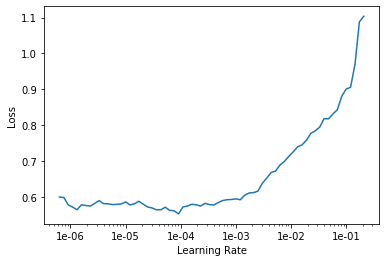

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(1e-5/2, lr/10))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.579935,0.627306,0.753333,1.000000,02:38
1,0.592292,0.590586,0.780000,1.000000,02:38
2,0.549695,0.592102,0.786667,1.000000,02:36
3,0.524601,0.568694,0.800000,1.000000,02:31
4,0.506370,0.573649,0.806667,1.000000,02:31


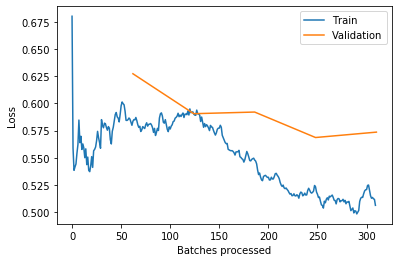

In [48]:
learn.recorder.plot_losses()

In [53]:
learn.save('resnet34-stage-4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


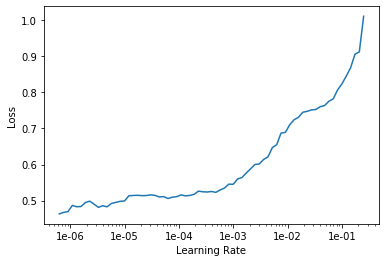

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
lr

0.001

In [56]:
learn.fit_one_cycle(5, slice(1e-6, lr/100))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.513572,0.578736,0.800000,1.000000,02:42
1,0.507019,0.578485,0.793333,1.000000,02:32
2,0.497066,0.570678,0.793333,1.000000,02:33
3,0.513079,0.571092,0.793333,1.000000,02:39
4,0.500236,0.563192,0.800000,1.000000,02:33


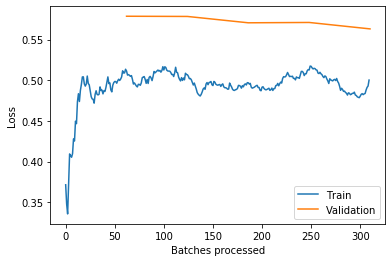

In [57]:
learn.recorder.plot_losses()

## Comment: This is a bad training. I'm going to discard this and live with "Res34-stage-4"

In [20]:
learn.load('resnet34-stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

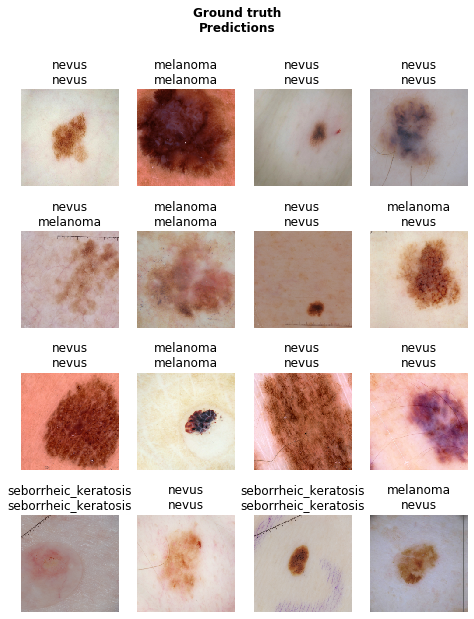

In [27]:
# This is how the learning performs with training data
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

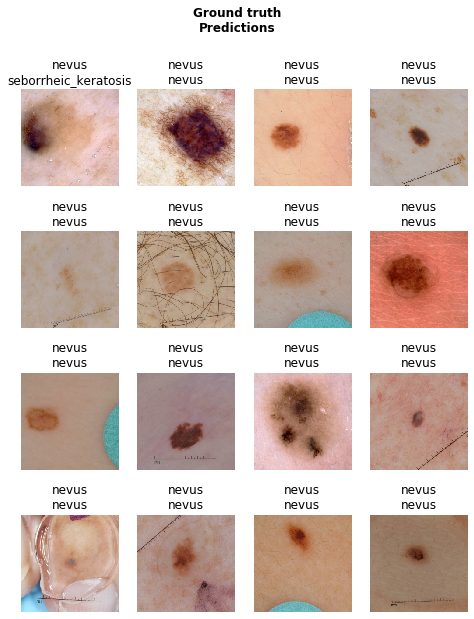

In [29]:
# This is how the learning performs with validation data (unseen data)
learn.show_results(ds_type=DatasetType.Valid, rows=4, figsize=(8,10))

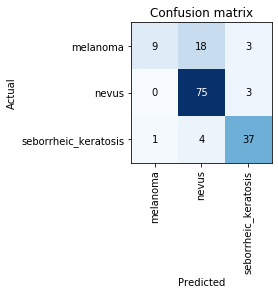

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Comment:<br>
This tells us that the Res34-classifier predicts the mojority of cancer to be *nevus* and we actually got a lot of the *melanoma* prediction wrong.

In [12]:
bs = 64
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=114, bs=bs
                            ).normalize(imagenet_stats)
bs = 32
data2 = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=bs
                            ).normalize(imagenet_stats)

In [34]:
learn = cnn_learner(data, models.resnet101, metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


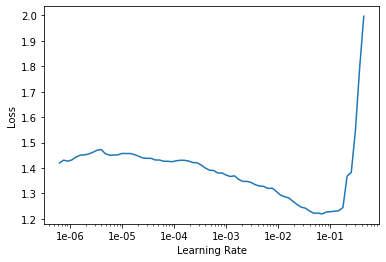

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-03
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.300752,0.930582,0.586667,02:45
1,1.113688,0.848098,0.653333,02:37
2,0.942289,0.807588,0.640000,02:52
3,0.813994,0.738434,0.673333,02:31
4,0.734833,0.733823,0.666667,02:48


In [23]:
learn.save("ResNet101-stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


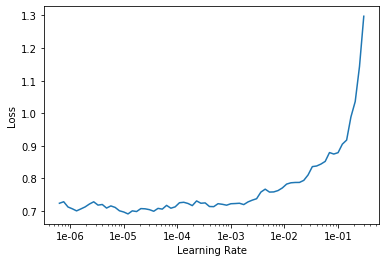

In [49]:
learn.load("ResNet101-stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(8, max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.656511,0.643765,0.760000,02:48
1,0.641321,0.604514,0.753333,02:55
2,0.600491,0.621247,0.740000,02:51
3,0.567487,0.571472,0.780000,02:59
4,0.522364,0.547034,0.780000,03:14
5,0.464557,0.511415,0.806667,03:07
6,0.411000,0.527182,0.780000,03:00
7,0.402985,0.509898,0.806667,02:57


In [51]:
learn.save("ResNet101-stage-2")

Remarks: not a good training. Discard this model

In [35]:
learn.load("ResNet101-stage-2")
# Change training dataset to higher resolution
learn.data = data2
data2.train_ds[0][0].shape

torch.Size([3, 224, 224])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


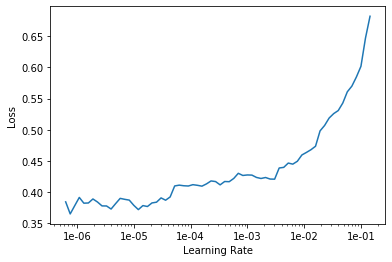

In [53]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [54]:
lr = 1e-4
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.435806,0.534556,0.793333,02:52
1,0.417948,0.518211,0.806667,03:00
2,0.385634,0.541915,0.793333,02:56
3,0.375966,0.547641,0.786667,02:57
4,0.375858,0.519161,0.806667,03:02


In [55]:
learn.save("ResNet101-stage-3")

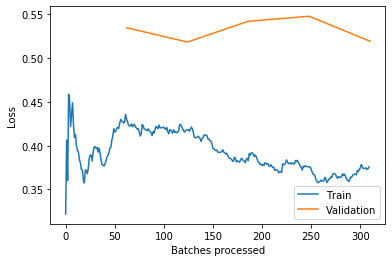

In [56]:
learn.recorder.plot_losses()

### Now the loss descent looks perfect

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


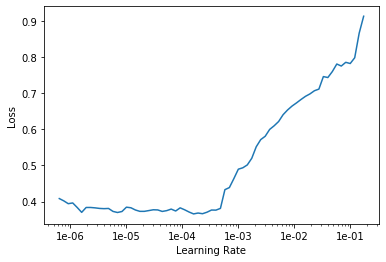

In [57]:
learn.load("ResNet101-stage-3")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.366994,0.530771,0.806667,02:57
1,0.355006,0.537353,0.813333,03:04
2,0.362173,0.548488,0.786667,03:01
3,0.350754,0.528267,0.793333,02:55
4,0.345579,0.530104,0.813333,03:00


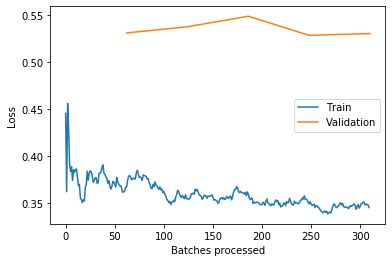

In [60]:
learn.recorder.plot_losses()

In [61]:
learn.save("ResNet101-stage-4")

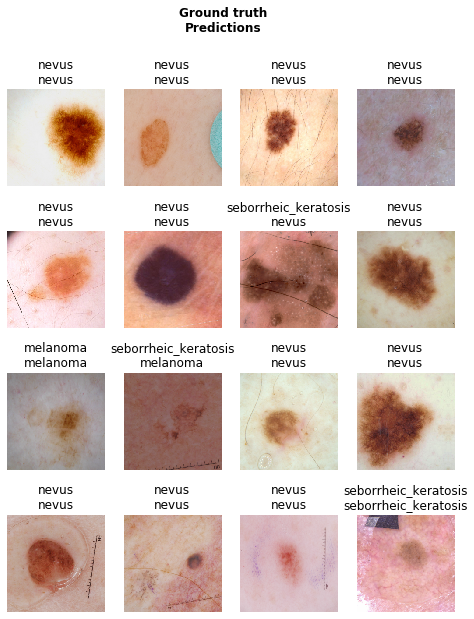

In [36]:
learn.load("ResNet101-stage-4")

#show how the model is doing with our training dataset
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

# Third base model to train: Resnet50

In [69]:
models.vgg??

In [50]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


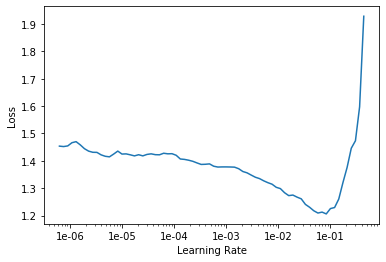

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
lr = 1e-02/2
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.210103,1.097439,0.660000,03:05
1,0.938602,0.827082,0.613333,03:11
2,0.782503,0.829604,0.640000,03:13
3,0.687184,0.742118,0.686667,03:17
4,0.636279,0.737540,0.693333,03:08


In [45]:
learn.fit_one_cycle(3,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.580516,0.787167,0.680000,03:27
1,0.604295,0.695326,0.720000,03:13
2,0.573068,0.714291,0.726667,03:14


In [46]:
learn.save("ResNet50-stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


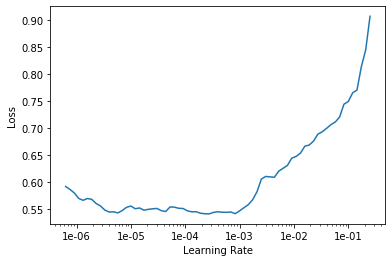

In [51]:
learn.load("ResNet50-stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [52]:
lr

0.005

In [53]:
learn.fit_one_cycle(5, slice(1e-04, lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.535748,0.652577,0.713333,03:20
1,0.546161,0.692958,0.740000,03:38
2,0.519076,0.534465,0.806667,03:13
3,0.457345,0.559672,0.746667,03:26
4,0.400033,0.548227,0.780000,03:30


In [54]:
learn.save("ResNet50-stage-2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


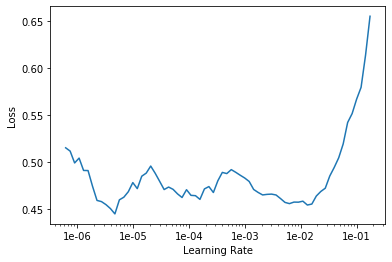

In [59]:
learn.load("ResNet50-stage-2")
learn.data = data2
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [60]:
lr = 1e-3
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.472500,0.559287,0.766667,03:13
1,0.452358,0.544212,0.780000,03:23
2,0.433311,0.585055,0.786667,03:35
3,0.412789,0.559479,0.793333,03:31


In [61]:
learn.save("ResNet50-stage-3")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


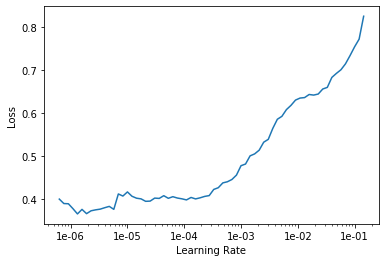

In [66]:
learn.load("ResNet50-stage-3")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(4, slice(1e-05,lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.409564,0.524830,0.773333,03:05
1,0.400361,0.481801,0.806667,03:24
2,0.369012,0.447462,0.826667,03:23
3,0.330915,0.432934,0.826667,03:28


In [69]:
learn.save("ResNet50-stage-4")

##  DenseNet169
### lastly we will prepare our fourth model using Densenet169 which is the largest model involved in this project

In [13]:
# learn = cnn_learner(data, models.densenet169, metrics = accuracy, callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])
learn = cnn_learner(data, models.densenet169, metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


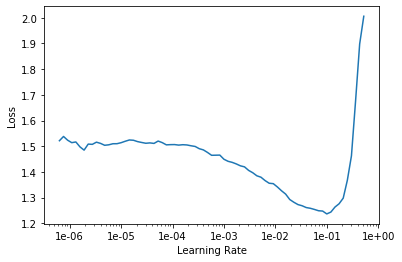

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr = 1e-02/2
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.246168,0.804863,0.680000,02:33
1,0.959343,1.088798,0.526667,02:34
2,0.776096,0.782288,0.660000,02:28
3,0.664548,0.772856,0.653333,02:30
4,0.588982,0.605663,0.753333,02:31
5,0.524178,0.581303,0.760000,02:36


In [30]:
learn.save("Densenet169-stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


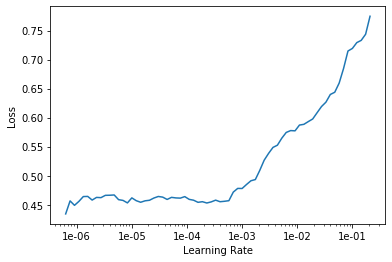

In [31]:
learn.load("Densenet169-stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.450711,0.594655,0.753333,02:32
1,0.460234,0.616252,0.760000,02:33
2,0.444327,0.622415,0.746667,02:42
3,0.410540,0.590687,0.760000,02:31
4,0.376992,0.575960,0.766667,02:37


#### Note: this Densenet seems to ourperform ResNets. 
at least up untill this stage

In [33]:
learn.save("Densenet169-stage-2")

In [27]:
learn.load("Densenet169-stage-2")
learn.data = data2
data2.train_ds[0][0].shape

torch.Size([3, 224, 224])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


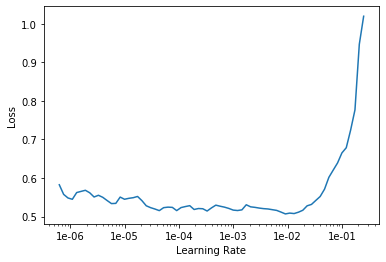

In [28]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.wd

0.01

In [30]:
lr = 1e-3
learn.fit_one_cycle(5, lr, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.501102,0.672442,0.733333,02:29
1,0.479323,0.676466,0.706667,02:30
2,0.427485,0.556550,0.773333,02:29
3,0.390449,0.545586,0.786667,02:27
4,0.359991,0.545413,0.773333,02:27


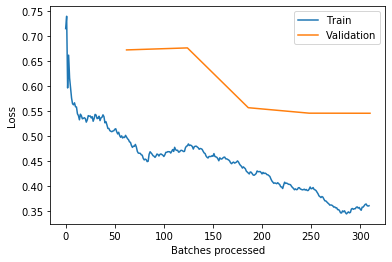

In [32]:
learn.save("Densenet169-stage-3")
learn.recorder.plot_losses()

## Here, we compare training the last stage with & without early stop

In [21]:
learn = cnn_learner(data2, models.densenet169, metrics = accuracy, callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])

In [33]:
learn = cnn_learner(data, models.densenet169, metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


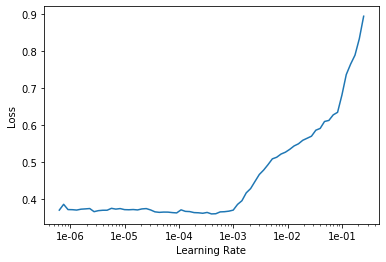

In [34]:
learn.load("Densenet169-stage-3")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.wd

0.01

In [36]:
learn.load("Densenet169-stage-3")
learn.fit_one_cycle(8, slice(1e-4, lr/5), wd=0.1)
print("This is without earlystop")

epoch,train_loss,valid_loss,accuracy,time
0,0.360679,0.574220,0.753333,02:34
1,0.350455,0.653639,0.740000,02:30
2,0.354925,0.581697,0.793333,02:29
3,0.339408,0.532869,0.773333,02:32
4,0.319358,0.618872,0.773333,02:30
5,0.281856,0.563695,0.800000,02:32
6,0.255778,0.563834,0.773333,02:31
7,0.227305,0.563165,0.773333,02:34


This is without earlystop


In [38]:
learn = cnn_learner(data2, models.densenet169, metrics = accuracy, callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=5)])
learn.load("Densenet169-stage-3")
learn.fit_one_cycle(8, slice(1e-4, lr/10), wd=0.1)
print("Stage-4 training with Earlystop")

epoch,train_loss,valid_loss,accuracy,time
0,0.331958,0.540757,0.773333,02:29
1,0.329098,0.521141,0.773333,02:33
2,0.326373,0.532283,0.800000,02:35
3,0.315831,0.530434,0.780000,02:27
4,0.314144,0.527382,0.786667,02:31
5,0.301381,0.517362,0.786667,02:31
6,0.296639,0.510195,0.780000,02:28
7,0.300293,0.515119,0.780000,02:30


Stage-4 training with Earlystop


In [39]:
learn.save("Densenet169-stage-4")

### Seems that the model with earlystop and weight decay=0.1 works better

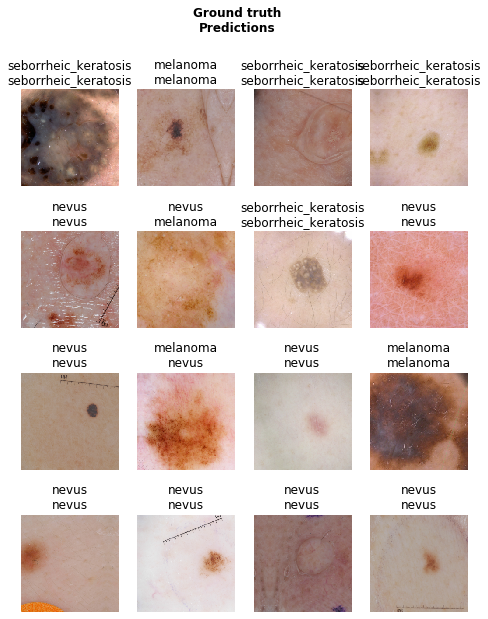

In [40]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

# VGG
The weak learner of the model stacking
Famous VGG-16

In [41]:
learn = cnn_learner(data, models.vgg16, metrics=accuracy, wd=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/projectx/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:30<00:00, 18108442.48it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


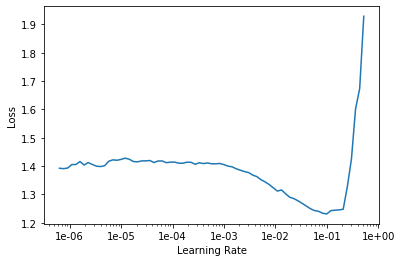

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
lr = 1e-3
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.360890,0.948095,0.506667,02:31
1,1.182545,0.804645,0.640000,02:28
2,0.993854,0.769019,0.653333,02:26
3,0.873442,0.805916,0.633333,02:27
4,0.800090,0.816678,0.626667,02:30
5,0.748540,0.817342,0.633333,02:28


In [44]:
learn.save("VGG-stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


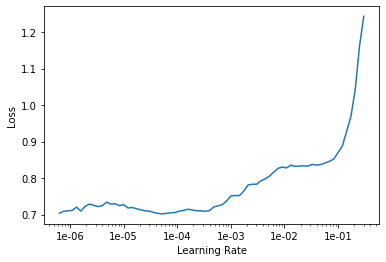

In [45]:
learn.load("VGG-stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.wd

0.1

In [47]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.698811,0.802924,0.633333,02:29
1,0.697870,0.776160,0.640000,02:28
2,0.685744,0.797773,0.600000,02:32
3,0.678443,0.790307,0.626667,02:30
4,0.665519,0.775804,0.646667,02:28


In [48]:
learn.save("VGG-stage-2")

In [49]:
learn.load("VGG-stage-2")
learn.data = data2
data2.train_ds[0][0].shape

torch.Size([3, 224, 224])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


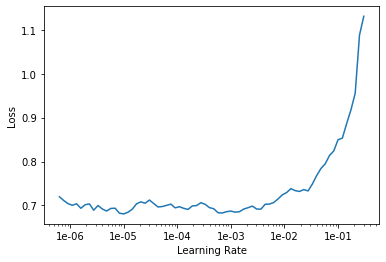

In [50]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [51]:
lr = 1e-3
learn.fit_one_cycle(6, lr, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.738446,0.710993,0.713333,02:26
1,0.684959,0.654642,0.733333,02:25
2,0.671931,0.671333,0.726667,02:26
3,0.644862,0.681751,0.693333,02:31
4,0.604187,0.660417,0.706667,02:28
5,0.591828,0.641561,0.740000,02:29


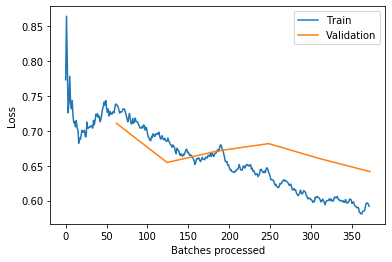

In [52]:
learn.save("VGG-stage-3")
learn.recorder.plot_losses()

## Train the last stage with strong Regularisation and Earlystop

In [14]:
learn = cnn_learner(data2, models.vgg16, metrics=accuracy,callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=5)])
learn.load("VGG-stage-3")
learn.wd = 0.1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0.1

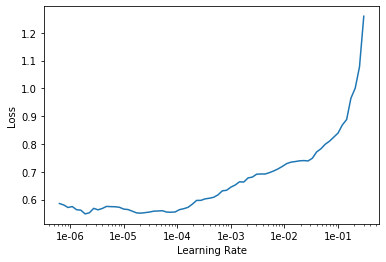

In [15]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
learn.wd

In [17]:
lr=1e-3
learn.fit_one_cycle(10, slice(2e-5, lr/5), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.578237,0.661752,0.733333,02:27
1,0.571205,0.614550,0.726667,02:30
2,0.569941,0.591844,0.760000,02:30
3,0.546163,0.517587,0.786667,02:33
4,0.532209,0.546430,0.773333,02:29
5,0.499444,0.517492,0.766667,02:31
6,0.474460,0.492382,0.786667,02:28
7,0.452823,0.488750,0.793333,02:27
8,0.440583,0.474628,0.806667,02:27
9,0.440963,0.473179,0.806667,02:33


In [18]:
interp = ClassificationInterpretation.from_learner(learn)

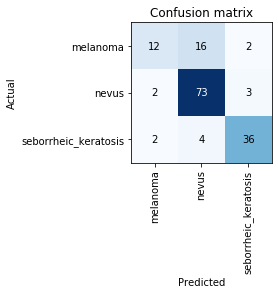

In [19]:
interp.plot_confusion_matrix()

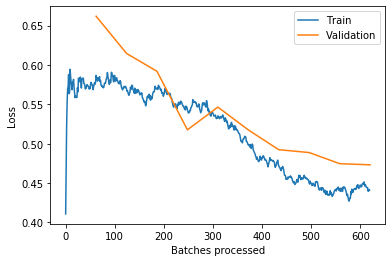

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.save("VGG-stage-4")

# Model stacking
Now we have 5 fully trained models around 80% accuracy <br>
Let's build a ensemble model to further push the performance

In [22]:
img = data2.train_ds[0][0]

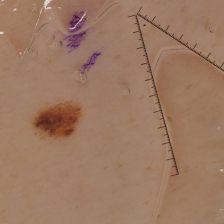

In [25]:
img

In [24]:
learn.predict(img)

(Category nevus, tensor(1), tensor([0.0087, 0.8858, 0.1056]))

In [26]:
preds, y = learn.get_preds(ds_type=DatasetType.Train)
preds.shape

torch.Size([1984, 3])

In [27]:
y.shape

torch.Size([1984])

In [28]:
preds[:5]

tensor([[0.7173, 0.2410, 0.0418],
        [0.1075, 0.8891, 0.0035],
        [0.0266, 0.9532, 0.0202],
        [0.0139, 0.7649, 0.2212],
        [0.0653, 0.9280, 0.0068]])

In [29]:
pred_np = preds.data.numpy()

In [30]:
pred_np.shape

(1984, 3)

## First we obtain the predictions of the five models on both training and validation data

#### Very importaly we wanna do two things here: get a handy function to help us get inference from our pretrained models, and turn off the shuffle bottom in the `train_dl` so that we  can construct our training dataset for the **Meta-Learner**

In [69]:
def get_prediction_in_numpy(learner, ds_type):
    preds, y = learner.get_preds(ds_type=ds_type)
    pred_np = preds.data.numpy()
    return pred_np ,y

In [70]:
data2.train_dl = data2.train_dl.new(shuffle=False)

In [71]:
learn = cnn_learner(data2, models.resnet34)
learn.load('resnet34-stage-4')
pred_train_ResNet34, y_train_R34 = get_prediction_in_numpy(learn, DatasetType.Train)
pred_valid_ResNet34, y_valid_R34 = get_prediction_in_numpy(learn, DatasetType.Valid)

In [72]:
learn = cnn_learner(data2, models.resnet101)
learn.load('ResNet101-stage-4')
pred_train_ResNet101, y_train_R101 = get_prediction_in_numpy(learn, DatasetType.Train)
pred_valid_ResNet101, y_valid_R101 = get_prediction_in_numpy(learn, DatasetType.Valid)

In [73]:
learn = cnn_learner(data2, models.resnet50)
learn.load('ResNet50-stage-4')
pred_train_ResNet50, y_train_R50 = get_prediction_in_numpy(learn, DatasetType.Train)
pred_valid_ResNet50, y_valid_R50 = get_prediction_in_numpy(learn, DatasetType.Valid)

In [74]:
learn = cnn_learner(data2, models.densenet169)
learn.load('Densenet169-stage-4')
pred_train_Densenet169, y_train_D = get_prediction_in_numpy(learn, DatasetType.Train)
pred_valid_Densenet169, y_valid_D = get_prediction_in_numpy(learn, DatasetType.Valid)

In [75]:
learn = cnn_learner(data2, models.vgg16)
learn.load('VGG-stage-4')
pred_train_VGG16, y_train_V = get_prediction_in_numpy(learn, DatasetType.Train)
pred_valid_VGG16, y_valid_V = get_prediction_in_numpy(learn, DatasetType.Valid)

## make sure that the "shuffle function" is turned-off so that all training labels are identical

In [145]:
print(torch.all(torch.eq(y_train_R34,y_train_R101)))
print(torch.all(torch.eq(y_train_R34,y_train_R50)))
print(torch.all(torch.eq(y_train_R34,y_train_D)))
print(torch.all(torch.eq(y_train_R34,y_train_V)))

tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)


In [147]:
print(torch.all(torch.eq(y_valid_R34,y_valid_R101)))
print(torch.all(torch.eq(y_valid_R34,y_valid_R50)))
print(torch.all(torch.eq(y_valid_R34,y_valid_D)))
print(torch.all(torch.eq(y_valid_R34,y_valid_V)))

tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)


## Here we have 3 features from each base model. Combine them, we should have a training_ds of 1984 by 3x5

In [81]:
train_np = np.concatenate((pred_train_ResNet50,pred_train_ResNet34,pred_train_ResNet101, pred_train_Densenet169,
                pred_train_VGG16), axis=1)

In [82]:
train_np.shape

(1984, 15)

In [86]:
import pandas as pd
train_df = pd.DataFrame(data=train_np)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.048890,0.923437,0.027673,0.003753,0.977487,0.018761,0.006910,0.953840,0.039250,0.003624,0.992082,0.004294,0.013974,0.927347,0.058679
1,0.000587,0.999345,0.000068,0.002338,0.992740,0.004922,0.003232,0.996478,0.000290,0.002959,0.996971,0.000070,0.008389,0.986490,0.005121
2,0.053956,0.876930,0.069114,0.115171,0.726184,0.158646,0.019895,0.923959,0.056146,0.027297,0.951161,0.021542,0.065824,0.910328,0.023848
3,0.000756,0.998518,0.000726,0.006489,0.977718,0.015793,0.002521,0.993788,0.003691,0.010776,0.988479,0.000745,0.021203,0.932883,0.045914
4,0.122426,0.874124,0.003450,0.022435,0.972459,0.005107,0.008544,0.987637,0.003819,0.024635,0.975039,0.000327,0.017378,0.968700,0.013922


In [89]:
train_df.shape

(1984, 15)

In [186]:
train_y = pd.DataFrame(data=y_train_D.data.numpy())

In [187]:
train_y.shape

(1984, 1)

In [93]:
valid_numpy = np.concatenate((pred_valid_ResNet50,pred_valid_ResNet34,pred_valid_ResNet101, pred_valid_Densenet169,
                pred_valid_VGG16), axis=1)

In [94]:
valid_numpy.shape

(150, 15)

In [95]:
valid_df = pd.DataFrame(data=valid_numpy)
valid_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.058523,0.934113,0.007364,0.061367,0.259176,0.679457,0.003059,0.974206,0.022735,0.125833,0.617662,0.256504,0.055613,0.768816,0.175570
1,0.080914,0.899060,0.020026,0.105425,0.841917,0.052658,0.028951,0.967380,0.003670,0.088706,0.900804,0.010490,0.015419,0.950106,0.034474
2,0.002985,0.995949,0.001067,0.002930,0.996546,0.000523,0.013305,0.977189,0.009507,0.001168,0.998827,0.000005,0.016076,0.982745,0.001180
3,0.040129,0.957000,0.002871,0.048167,0.942118,0.009715,0.215442,0.732333,0.052225,0.036637,0.938058,0.025305,0.189302,0.792961,0.017737
4,0.302244,0.683915,0.013842,0.344192,0.470124,0.185684,0.278683,0.668459,0.052858,0.373104,0.566821,0.060075,0.152156,0.684681,0.163163


In [185]:
valid_y = pd.DataFrame(data=y_valid_D.data.numpy())
valid_y.shape

(150, 1)

# Meta-learner selection

In [188]:
train_df.to_csv("train_df")
train_y.to_csv("train_y")
valid_df.to_csv("valid_df")
valid_y.to_csv("valid_y")

In [ ]:
train_df = pd.read_csv("train_df")
train_y = pd.read_csv("train_y")
valid_df = pd.read_csv("valid_df")
valid_y = pd.read_csv("valid_y")

In [263]:
from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
import xgboost as xgb

In [209]:
MLA = [
#     Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators=100),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_estimators=100),

#     Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
#     GLM
#     linear_model.LogisticRegression(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifier(),
#     linear_model.Lasso(),
#     linear_model.ElasticNet(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
#     Kernel Method
#     KernelRidge(),
    
#     Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
#     Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
#     svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
#     Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier(learning_rate=0.01, gamma=0.1, max_depth=2, n_estimators=500, min_child_weight=1, seed=0)    
    ]
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6)

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
# MLA_predict = Y_normal

In [210]:
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    print(f'training etimator {row_index}, {MLA_name}')
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train_df, train_y[0], cv  = cv_split,scoring='accuracy', return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(train_df, train_y[0])
#     MLA_predict[MLA_name] = alg.predict(train_cl[ML_columns])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

training etimator 0, AdaBoostClassifier
training etimator 1, BaggingClassifier
training etimator 2, ExtraTreesClassifier
training etimator 3, GradientBoostingClassifier
training etimator 4, RandomForestClassifier
training etimator 5, GaussianProcessClassifier
training etimator 6, PassiveAggressiveClassifier
training etimator 7, RidgeClassifier
training etimator 8, SGDClassifier
training etimator 9, Perceptron
training etimator 10, BernoulliNB
training etimator 11, GaussianNB
training etimator 12, KNeighborsClassifier
training etimator 13, SVC


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/project

training etimator 14, LinearSVC
training etimator 15, DecisionTreeClassifier
training etimator 16, ExtraTreeClassifier
training etimator 17, LinearDiscriminantAnalysis


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/di

training etimator 18, QuadraticDiscriminantAnalysis
training etimator 19, XGBClassifier


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/discriminant

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
7,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.936134,0.937081,0.0219696,0.00391414
19,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.952101,0.936577,0.0314184,1.27246
8,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.941849,0.936577,0.0244322,0.00746207
14,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.939916,0.936242,0.0193645,0.0111704
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1,0.93557,0.0292813,0.100099
13,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.934874,0.93406,0.0197595,0.0708717
17,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.934958,0.933725,0.0176174,0.0190848
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",1,0.933389,0.0196309,0.195676
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.938739,0.933389,0.0196309,2.01004
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.999328,0.933221,0.0346402,0.693968


### Not very suprising that XGBoost is doing exceptionally well
RidgeCLassifier is also quite good in this case. However, we will use XGBoost as it's more versatile as the tuning process usually give a larger boost as compared to default parameters.

In [212]:
cv = model_selection.StratifiedKFold(n_splits=7, random_state=7)

In [213]:
from hyperopt import space_eval

In [217]:
class Bayesian_Optimizer:
    def __init__(self, clf, param_space, scoring_metrics ='accuracy', 
                 max_eval = 100 , cv = cv ,train_set=train_df, train_y = train_y[0]):
        self.clf = clf
        self.param_space = param_space
        self.max_eval = max_eval
        self.train_set = train_set
#         self.X_col = X_col
        self.train_y = train_y
        self.scoring_metrics = scoring_metrics
        self.cv = cv
        self.epoch = 1
        
    def hyperopt_run(self, space):
        model = self.clf(**space)
        score = cross_val_score(model,
                                self.train_set, 
                                self.train_y, 
#                                 cv  = self.cv,
                                cv=5,
                                scoring=self.scoring_metrics                     
                               )
        print("Epoch : {}: {} Score {:.3f} params {}".format(self.epoch, self.scoring_metrics,score.mean(), space))
        self.epoch+=1
        return {'loss':(1 - score.mean()), 'status': STATUS_OK}
    def HP_optimization(self):
        trials = Trials()
        best = fmin(fn=self.hyperopt_run,
                    space=self.param_space,
                    algo=tpe.suggest,
                    max_evals=self.max_eval
                    )
        best_option = space_eval(self.param_space, best)
        self.best_option = best_option
        print('the best option is:', best_option)
        clf = self.clf(**self.best_option)
        final_score = cross_val_score(clf,
                                      self.train_set,
                                      self.train_y,
                                      cv  = self.cv,
                                      scoring=self.scoring_metrics                            
                               )
        print('Cooresponding loss:', final_score.mean(), sep='\n')

## This hyper-parameter set-up give us 93.8% accuracy on the training 5-fold crossvalidation

In [257]:
XGB.best_option

{'colsample_bytree': 0.42873826843749635,
 'gamma': 0.7142909510302903,
 'learning_rate': 0.010489751240981171,
 'max_depth': 3,
 'min_child_weight': 5.672606149867924,
 'n_estimators': 175,
 'subsample': 0.9685146619325555}

In [258]:
model = XGBClassifier(**XGB.best_option)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.42873826843749635,
              gamma=0.7142909510302903, learning_rate=0.010489751240981171,
              max_delta_step=0, max_depth=3, min_child_weight=5.672606149867924,
              missing=None, n_estimators=175, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9685146619325555, verbosity=1)

In [249]:
from sklearn.metrics import accuracy_score
def get_accuracy(model):
#     print(f'the model is {model}\n')
    model.fit(train_df,train_y[0])
    preds = model.predict(valid_df)
    
    return accuracy_score(preds, ground_truth)

In [262]:
print(f'The prediction on the validation dataset is {get_accuracy(model)*100:.2f}%')

The prediction on the validation dataset is 85.33%


In [292]:
train_y.rename(columns={0:"target"},inplace=True)

In [298]:
train_y['target'].value_counts()

1    1372
0     358
2     254
Name: target, dtype: int64

In [304]:
train_y = pd.get_dummies(train_y['target'])
train_y.shape

(1984, 3)

In [325]:
train_y_np = train_y.to_numpy()
train_y_np.shape

(1984, 3)

In [323]:
preds = model.predict(train_df)
preds.shape

(1984,)

In [324]:
preds = pd.get_dummies(pd.DataFrame(preds)[0])
preds_np = preds.to_numpy()
preds_np.shape

(1984, 3)

In [326]:
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(data.c):
    fpr[i], tpr[i], _ = roc_curve(train_y_np[:,i], preds_np[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC are
fpr["micro"], tpr["micro"], _ =roc_curve(train_y_np.ravel(), preds_np.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Category 1 Score: 0.92
Category 2 Score: 0.94
Category 3 Score: 0.97


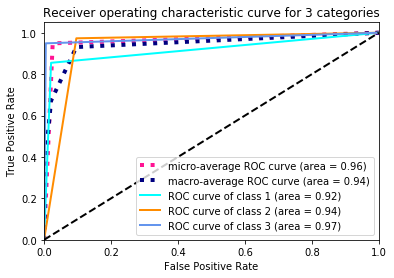

In [334]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(data.c)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= data.c

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
for i in range(3):
    print(f"Category {i+1} Score: {roc_auc[i]:0.2f}")

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for 3 categories')
plt.legend(loc="lower right")
plt.show()